In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import random
from copy import deepcopy
import _pickle as pickle
import gc
from multiprocess import Pool
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import KBinsDiscretizer
import tensorflow.keras.utils as np_utils
from tensorflow.keras.optimizers import Adam, SGD
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile, protocol=4)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

class Discretiser:
    def __init__(self, nbins):
        self.nbins = nbins-1
        self.map_to = np.arange(self.nbins)/self.nbins
        
    def fit(self, X):
        ## X is a one dimension np array
        self.map_from = np.quantile(X, self.map_to)
        
    def transform(self, X):
        X1 = (np.interp(X, self.map_from, self.map_to, left=0, right=1, period=None) * self.nbins).astype(int)
        return X1

## Modeling

In [ ]:
train = load('train_train')

In [ ]:
for user, data in tqdm(train.groupby('user_id'), total = train['user_id'].nunique()):
    save(data, str(user), 'individual_users')

In [ ]:
gc.collect()

In [ ]:
test_user = train[train['user_id'] == 115]

In [ ]:
def build_user_sequence(df_user):
    import numpy as np
    df_user =  df_user.sort_values(by = 'timestamp')
    df_user.index = list(range(df_user.shape[0]))
    
    df_user['content_type'] =  df_user['content_type_id'].apply(lambda x : 'q' if x == 0 else 'l')
    df_user['content_seq'] = df_user['content_type'].astype(str) + '_' + df_user['content_id'].astype(str)
    
    ## Encoder
    exercise_id = df_user['content_seq'].values
    container_id = df_user['task_container_id'].values
    timestamp = df_user['timestamp'].values/1000  ## Conversion in s
    
    ## Decoder
    correctness = df_user['answered_correctly'].values
    answer = df_user['user_answer'].values
    
    elapsed_time = df_user['prior_question_elapsed_time'].fillna(0).values[1:]/1000 ## Already Padded ## Conversion in s
    prior_question_had_explanation = df_user['prior_question_had_explanation'].fillna(0).values[1:]*1 ## Already Padded
    
    lag_time = np.concatenate([[0],timestamp[1:] - timestamp[:-1] + elapsed_time])
    
    dico = {
        'exercise_id' : exercise_id,
        'container_id' : container_id,
        'timestamp' : timestamp,
        'correctness' : correctness,
        'answer' : answer, 
        'elapsed_time' : elapsed_time,
        'prior_question_had_explanation' : prior_question_had_explanation,
        'lag_time' : lag_time
    }
    return dico
    

In [ ]:
%%time
dico = build_user_sequence(test_user)

In [ ]:
dico['lag_time']

In [ ]:
batch_size = 2000
count = 0
vect = []
p = Pool(12)

for elt in tqdm(train.groupby('user_id'), total = train['user_id'].nunique()):
    vect.append(elt)
    if len(vect) == batch_size:
        vect = np.array(vect)
        vect_user = vect[:,0]
        vect_data = vect[:,1]
        vect = []
        
        processed_dico = p.map(build_user_sequence, vect_data)
        
        # saving as batches of 2000
        dico_user = {}
        for i, elt in enumerate(vect_user):
            dico_user[elt] = processed_dico[i]
        save(dico_user, 'batch_'+str(count), 'user_batch_saint_2000')
        
        # saving as batches of 100
        dico_user = {}
        count1 = 0
        for i, elt in enumerate(vect_user):
            dico_user[elt] = processed_dico[i]
            if len(dico_user.keys()) == 100:
                save(dico_user, 'batch_'+str(count)+'_'+str(count1), 'user_batch_saint_100')
                dico_user = {}
                count1+=1
        count += 1
        
p.close()

In [ ]:
test_user.head()

## Tokenization and discretisation

In [ ]:
## timestamp encoder
dico_user = load('batch_'+str(0), 'user_batch_saint_2000')
el = []
for elt in dico_user:
    ela = dico_user[elt]['timestamp']
    ela[np.isnan(ela)] = 0
    el += list(ela)
timestamp_enc = Discretiser(300)
timestamp_enc.fit(el)    

In [ ]:
## Elapsed time encoder
dico_user = load('batch_'+str(0), 'user_batch_saint_2000')
el = []
for elt in dico_user:
    ela = dico_user[elt]['elapsed_time']
    ela[np.isnan(ela)] = 0
    el += list(ela)
elapsed_enc = Discretiser(300)
elapsed_enc.fit(el)    

In [ ]:
## Lag time encoder
dico_user = load('batch_'+str(0), 'user_batch_saint_2000')
el = []
for elt in dico_user:
    ela = dico_user[elt]['lag_time']
    ela[np.isnan(ela)] = 0
    el += list(ela)
lag_time_enc = Discretiser(300)
lag_time_enc.fit(el)    

In [ ]:
## Question mean encoder
dico_question = load('dico_questions_mean')
val = list(dico_question.values())
qmean_enc = Discretiser(300)
qmean_enc.fit(val) 

In [ ]:
## Saving
save((timestamp_enc, elapsed_enc, lag_time_enc, qmean_enc), 'discrete_encoders')

In [ ]:
## Building tokenizer
lectures = pd.read_csv('lectures.csv')
questions = pd.read_csv('questions.csv')
user_answer = np.array([-1,0,1,2,3])
answered_correctly = np.array([-1,0,1])

lectures_id = lectures['lecture_id'].unique()
question_id = questions['question_id'].unique()

lectures_id = ['l_' +  elt for elt in  lectures_id.astype(str)]
question_id = ['q_' +  elt for elt in  question_id.astype(str)]

all_tokens = np.array(['[PAD]', '[CLS]', '[SEP]', '[MASK]'] + lectures_id + question_id)


lectures_id_1 = [elt + "_-1" for elt in lectures_id]
question_id_0 = [elt + "_0" for elt in question_id]
question_id_1 = [elt + "_1" for elt in question_id]

tokenizer = Tokenizer(filters = '')

tokenizer.fit_on_texts(
    all_tokens
)


all_tokens_res = np.array(['[PAD]', '[CLS]', '[SEP]', '[MASK]'] + lectures_id_1 + question_id_0 + question_id_1)

tokenizer_res = Tokenizer(filters = '')

tokenizer_res.fit_on_texts(
    all_tokens_res
)

save((tokenizer, tokenizer_res), 'tokenizers')

In [ ]:
def create_dictionnaries():
    df = pd.read_csv('questions.csv')
    df1 = pd.read_csv('lectures.csv')

    def apply(x):
        return 'q_'+str(x)

    def apply1(x):
        return 'l_'+str(x)

    def to_tab(x):
        if str(x)!='nan':
            x = np.array(str(x).split(' ')).astype(int)
        else:
            x = []
        x.sort()
        return x

    df['tag'] = df['tags'].apply(to_tab)
    df['qu'] = df['question_id'].apply(apply)
    df1['l'] = df1['lecture_id'].apply(apply1)

    ## unique tags part
    tags_to_utags = {}
    count = 0
    for elt in df1['tag']:
        if elt in tags_to_utags:
            1
        else:
            tags_to_utags[str(elt)] = count
            count+=1

    for elt in df['tags']:
        if elt in tags_to_utags:
            1
        else:
            tags_to_utags[elt] = count
            count+=1
    df['utags'] = df['tags'].astype(str).replace(tags_to_utags)
    df1['utags'] = df1['tag'].astype(str).replace(tags_to_utags)

    ## Graph tags part
    dico_l = {}
    for t, data in df1.groupby('tag'):
        dico_l[t] = data['l'].unique()

    import networkx as nx
    G = nx.Graph()
    G.add_nodes_from(df['qu'])
    G.add_nodes_from(df1['l'])

    for i, elt in enumerate(tqdm(df['tag'])):
        for j in elt:
            try:
                lec = dico_l[j]
            except:
                lec = []
            for k in lec:
                G.add_edge(df['qu'].iloc[i], k)

    co = list(nx.connected_components(G))

    tags_to_gtags = {}
    count = 0
    for i, elt in enumerate(tqdm(co)):
        for j in elt:
            tags_to_gtags[j] = i

    df['gtags'] = df['qu'].replace(tags_to_gtags)
    df1['gtags'] = df1['l'].replace(tags_to_gtags)
    
    df1['tag'] = df1['tag'].apply(lambda x  :[x])
    
    dico_utags = {}
    dico_gtags = {}
    dico_parts = {}
    dico_tags = {}
    
    for pair in zip(df['qu'], df['utags'], df['gtags'], df['part'], df['tag']):
        dico_utags[pair[0]] = pair[1]
        dico_gtags[pair[0]] = pair[2]
        dico_parts[pair[0]] = pair[3]
        dico_tags[pair[0]] = pair[4]
        
    for pair in zip(df1['l'], df1['utags'], df1['gtags'], df1['part'], df1['tag']):
        dico_utags[pair[0]] = pair[1]
        dico_gtags[pair[0]] = pair[2]
        dico_parts[pair[0]] = pair[3]
        dico_tags[pair[0]] = pair[4]
        
    
    
    return dico_utags, dico_gtags, dico_parts, dico_tags

dico_utags, dico_gtags, dico_parts, dico_tags = create_dictionnaries()

save((dico_utags, dico_gtags, dico_parts, dico_tags), 'dico_tags')

## Data Generator

In [ ]:
## Sequence Modelling
sequence_ids   emb1_main # tokenizer values + cls, pad et mask tokens
answer_corr    emb2     # 0,1,2,+mask = 3
part           emb8     # 6 parts
timestamp      emb3     float discretized in 300 int values
answer         emb4     # 0,1,2,3,4,+mask = 5
elapsed_time   emb5     float discretized in 300 int values
explained      emb6     # 2 possible, lectures put to 0
avg_correct    emb7     float discretized in 300 int values

## MLM loss
sequence unmasked
answer_corr unmasked

## Next answer prediction loss
[CLS] Query [SEP] Sequence Model

Sequence Model as in sequence modelling

Query
question_id     ## id question      
answer_corr     ## Mask token
part            ## 6 parts
timestamp       float discretized in 300 values
answer          ## Masked to -1
elapsed_time    ## 0
explained   0   ## 0
avg_correct     ## average score of the question discretized in 300 int values

output : unmasked answer_corr    

In [2]:
import tensorflow as tf
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,batch_size=32, max_len = 128, folder = 'user_batch_saint_100', strategy = 'begin', mask_rate = 0.15, seq_mask_rate = 0.5, bidirectionnal = True):
        self.batch_size = batch_size
        self.tokenizer, self.tokenizer_res = load('tokenizers')
        self.max_len = max_len
        self.folder = folder
        self.dico_question = load('dico_questions_mean')
        self.dico_utags, self.dico_gtags, self.dico_parts, self.dico_tags = load('dico_tags')
        self.timestamp_enc, self.elapsed_enc,self.lag_time_enc, self.qmean_enc = load('discrete_encoders')
        self.strategy = strategy
        self.mask_rate = mask_rate
        self.seq_mask_rate = seq_mask_rate
        self.bidirectionnal = bidirectionnal
        self.num_tags = 188
        
    def __len__(self):
        return 1000000
    
    def initiate_dico(self):
        list_encoder = ['exercise_enc','parts', 'tags', 'question_mean','question_mean_bis', 'timestamp_num', 'timestamp_cats']
        list_decoder = ['exercise_dec', 'correct_dec']
        list_output = ['correct_out']
        
        dico_input = {}
        for elt in list_encoder + list_decoder:
            if elt == 'exercise_enc' or elt == 'exercise_dec':
                dico_input[elt] = np.zeros((self.batch_size, self.max_len)).astype(str)
            else:
                if elt == 'question_mean_bis' or elt == 'timestamp_num':
                    dico_input[elt] = np.zeros((self.batch_size, self.max_len)).astype('float32')
                elif elt != 'tags':
                    dico_input[elt] = np.zeros((self.batch_size, self.max_len)).astype('int32')
                else:
                    dico_input[elt] = np.zeros((self.batch_size, self.max_len, self.num_tags)).astype('int32')
        
        dico_output = {}
        for elt in list_output:
            if elt == 'exercise':
                dico_output[elt] = np.zeros((self.batch_size, self.max_len)).astype(str)
            else:
                dico_output[elt] = np.zeros((self.batch_size, self.max_len)).astype('int32')
        return dico_input, dico_output

    def map_part(self, ids):
        def replace_dico_part(x):
            try:
                return self.dico_parts[x]
            except:
                return 0
        return np.array(list(map(replace_dico_part,ids)))
    
    def map_utags(self, ids):
        def replace_dico_utags(x):
            try:
                if str(self.dico_utags[x]) != 'nan':
                    return str(self.dico_utags[x])
                else:
                    return 0
            except:
                return 0
        return np.array(list(map(replace_dico_utags,ids)))
    
    def map_gtags(self, ids):
        def replace_dico_gtags(x):
            try:
                if str(self.dico_gtags[x]) != 'nan':
                    return str(self.dico_gtags[x])
                else:
                    return 0
            except:
                return 0
        return np.array(list(map(replace_dico_gtags,ids)))
    
    def map_mean(self, ids):
        def replace_dico_question(x):
            try:
                return self.dico_question[x]
            except:
                return 0.5
        return np.array(list(map(replace_dico_question,ids))).astype('float32')

    def map_tags(self, ids):
        tags = np.zeros((len(ids), 188))

        def map_apply(x):
            try:
                return self.dico_tags[x]
            except:
                return []

        found_tags = list(map(map_apply, ids))

        for i , elt in enumerate(found_tags):
            for j in elt:
                tags[i,j] += 1
        return tags
    
    def update_dico(self, dico_input, dico_output, input_vals, output_vals, i):
        list_encoder = ['exercise_enc','parts', 'tags', 'question_mean','question_mean_bis', 'timestamp_num', 'timestamp_cats']
        list_decoder = ['exercise_dec', 'correct_dec']
        list_output = ['correct_out']
        
        for j, elt in enumerate(list_encoder + list_decoder):
            dico_input[elt][i] = input_vals[j]
        
        for j, elt in enumerate(list_output):
            dico_output[elt][i] = output_vals[j]
        return dico_input, dico_output

    def remove_na(self, x):
        x = np.array(list(x))
        x[np.isnan(x)] = 0
        return x
    
    def apply_mask(self, x, mask, pad_token, mask_token):
        x_out = []
        x_in = []
        for i, elt in enumerate(mask):
            if mask[i] == 1:
                x_out.append(x[i])
                x_in.append(mask_token)
            else:
                x_out.append(pad_token)
                x_in.append(x[i])
        return np.array(x_in), np.array(x_out)

    def build_sequence(self, user_history):
        dico_sequence = deepcopy(user_history)        
        dico_sequence['elapsed_time'] = self.remove_na(dico_sequence['elapsed_time'])
        dico_sequence['lag_time'] = self.remove_na(dico_sequence['lag_time'])
        dico_sequence['prior_question_had_explanation'] = self.remove_na(dico_sequence['prior_question_had_explanation'])
        
        dico_sequence['elapsed_time'] = np.concatenate([dico_sequence['elapsed_time'], [0]])
        dico_sequence['prior_question_had_explanation'] = np.concatenate([dico_sequence['prior_question_had_explanation'], [0]])
        
        
        ## Cut sequence
        if self.strategy == 'begin':
            for elt in dico_sequence:
                dico_sequence[elt] = dico_sequence[elt][:self.max_len]
        else:
            for elt in dico_sequence:
                dico_sequence[elt] = dico_sequence[elt][-self.max_len:]
        
        
        dico_sequence['exercise_id_out'] = dico_sequence['exercise_id']
        dico_sequence['correctness_out'] = dico_sequence['correctness']
        dico_sequence['answer_out'] = dico_sequence['answer']
        
        dico_sequence['exercise_correct'] = np.array([str(dico_sequence['exercise_id'][i]) + '_' + str(dico_sequence['correctness'][i]) for i in range(len(dico_sequence['exercise_id']))])
        
        ## Pad sequence
        pad_tokens = ['[PAD]', 0, 0, -1, -1, 0, 0, 0, '[PAD]', -1, -1, '[PAD]']
        for j, elt in enumerate(dico_sequence):
            size = len(dico_sequence[elt])
            if size <= self.max_len:
                adding = self.max_len - size
                tok = pad_tokens[j]
                if type(tok) == str:
                    add = np.array([tok for elt in range(adding)])
                else:
                    add = np.zeros(adding) + tok
                dico_sequence[elt] = np.concatenate([dico_sequence[elt], add], axis = 0)
#                 print(dico_sequence[elt].shape)
        
        dico_sequence['correctness'][dico_sequence['correctness'] == -1] = 2
    
        input_vals = [
            dico_sequence['exercise_id'],
            self.map_part(dico_sequence['exercise_id']),
            self.map_tags(dico_sequence['exercise_id']),
            self.qmean_enc.transform(self.map_mean(dico_sequence['exercise_id'])),
            self.map_mean(dico_sequence['exercise_id']),
            dico_sequence['timestamp'],
            self.timestamp_enc.transform(dico_sequence['timestamp']),
            
            np.concatenate([['[CLS]'], dico_sequence['exercise_id'][:-1]]),
            np.concatenate([[2], dico_sequence['correctness'][:-1]]),
            
        ]
#         print(np.concatenate([['[CLS]'], dico_sequence['exercise_correct'][:-1]]))

        dico_sequence['correctness_out'][dico_sequence['correctness_out'] == -1] = 2

        output_vals = [
            dico_sequence['correctness_out'],
        ]
            
        return input_vals,output_vals
    

    def __getitem__(self, index):
        ## Load random batch
        file_name = random.choice(os.listdir('./'+self.folder))
        dico_user = load(file_name.split('.')[0], self.folder)
        
        list_user = np.random.choice(list(dico_user.keys()), size = self.batch_size)
        
        dico_input, dico_output = self.initiate_dico()
        
        
        for i, elt in enumerate(list_user):
            user_history = dico_user[elt]
            input_vals, output_vals = self.build_sequence(user_history)
            dico_input, dico_output = self.update_dico(dico_input, dico_output, input_vals, output_vals, i)

        x = deepcopy(dico_input['exercise_enc'])
        dico_input['exercise_enc'] = np.array(self.tokenizer.texts_to_sequences(x.tolist()))
        
        
        
        x = deepcopy(dico_input['exercise_dec'])
        dico_input['exercise_dec'] = np.array(self.tokenizer.texts_to_sequences(x.tolist()))
        
        X = []
        for elt in dico_input:
            if elt != 'question_mean_bis' and elt != 'timestamp_num':
                X.append(np.array(list(dico_input[elt])).astype('int32'))
            else:
                X.append(np.array(list(dico_input[elt])).astype('float32').reshape((self.batch_size, self.max_len, 1)))
            
        y = dico_output['correct_out'].astype('int32')
        return X, y

    def on_epoch_end(self):
        pass

    def __get_data(self, batch):
        pass

In [21]:
gen = DataGenerator(batch_size=2000, max_len = 100, folder = 'user_batch_saint_2000', strategy = 'end', mask_rate = 0.15, seq_mask_rate = 1, bidirectionnal = False)

In [19]:
%%time 
x, y = gen[1]

Wall time: 789 ms


In [23]:
dico_input, dico_output = gen.initiate_dico()

for i in tqdm(range(1)):
    dico_user = load('batch_'+str(150), 'user_batch_saint_2000')
    for j, elt in enumerate(tqdm(dico_user.keys())):
        user_history = dico_user[elt]
        input_vals, output_vals = gen.build_sequence(user_history)
        dico_input, dico_output = gen.update_dico(dico_input, dico_output, input_vals, output_vals, j)
    
x = deepcopy(dico_input['exercise_enc'])

# dico_input['exercise_enc'] = np.array(gen.tokenizer.texts_to_sequences([" ".join(list(x)[elt]) for elt in tqdm(range(len(x)))]))

# print('s1 tokenized')
# x = deepcopy(dico_input['exercise_dec'])

# dico_input['exercise_dec'] = np.array(gen.tokenizer.texts_to_sequences([" ".join(list(x)[elt]) for elt in tqdm(range(len(x)))]))

# print('s2 tokenized')

# X = []
# for elt in dico_input:
#     if elt != 'question_mean_bis' and elt != 'timestamp_num':
#         X.append(dico_input[elt].astype('int32'))
#     else:
#         X.append(np.array(list(dico_input[elt])).astype('float32').reshape((gen.batch_size, gen.max_len, 1)))

# y = dico_output['correct_out'].astype('int32')

# save((X, y), 'preprocessed_batch', 'preprocessed_batch')

In [31]:
x.tolist()

[['q_4418',
  'q_8726',
  'q_11464',
  'q_4614',
  'q_9942',
  'q_3878',
  'q_4417',
  'q_6318',
  'q_5196',
  'q_6637',
  'q_6640',
  'q_6638',
  'q_6639',
  'l_5752',
  'q_756',
  'q_482',
  'q_307',
  'q_1334',
  'q_665',
  'q_738',
  'q_866',
  'q_403',
  'q_405',
  'q_981',
  'q_236',
  'q_438',
  'q_6731',
  'q_6730',
  'q_6732',
  'q_6729',
  'q_10074',
  'q_10076',
  'q_10075',
  'q_10077',
  'q_6873',
  'q_6875',
  'q_6876',
  'q_6874',
  'q_6763',
  'q_6761',
  'q_6762',
  'q_6764',
  'q_6872',
  'q_6870',
  'q_6869',
  'q_6871',
  'q_6758',
  'q_6759',
  'q_6757',
  'q_6760',
  'q_5612',
  'q_4764',
  'q_9104',
  'q_3643',
  'l_12354',
  'l_5266',
  'l_22390',
  'q_2419',
  'q_2420',
  'q_2421',
  'q_1986',
  'q_1985',
  'q_1987',
  'q_2063',
  'q_2065',
  'q_2064',
  'q_1982',
  'q_1984',
  'q_1983',
  'q_1534',
  'q_1532',
  'q_1533',
  'q_6815',
  'q_6816',
  'q_6814',
  'q_6813',
  'q_6753',
  'q_6756',
  'q_6754',
  'q_6755',
  'q_6583',
  'q_6581',
  'q_6584',
  'q_658

In [32]:
c = gen.tokenizer.texts_to_sequences(x.tolist())

In [33]:
np.array(c)

array([[ 4841,  9149, 11887, ...,   115,   134,   355],
       [ 6722,   544,  6331, ...,     1,     1,     1],
       [ 9341,  5503,  5102, ...,  8368,  9591,  6867],
       ...,
       [ 6099,  4598,  6015, ...,     1,     1,     1],
       [ 8323,  8299,   598, ...,     1,     1,     1],
       [ 8323,  8299,   598, ...,     1,     1,     1]])

In [ ]:
np.unique(a, return_counts =True)

In [ ]:
for elt in dico_input:
    print(dico_input[elt].shape)

In [ ]:
%%time
x, y = gen[0]

In [ ]:
for elt in x:
    print(elt.shape)

In [ ]:
y.shape

In [2]:
from tf_transformers2 import *
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
class Time2Vector(tf.keras.layers.Layer):
    def __init__(self, seq_len,d_model,  **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len
        self.linear_dense = tf.keras.layers.Dense(d_model, activation = 'tanh')
        self.periodic_dense = tf.keras.layers.Dense(d_model, activation = 'sigmoid')

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
        return self.linear_dense(time_linear), self.periodic_dense(time_periodic)
  


In [ ]:
class custEncoder(tf.keras.layers.Layer):  
    def __init__(self, num_layers = 2, d_model = 512, num_heads = 8, dff = 1024, input_vocab_size = 14000, maximum_position_encoding = 512, rate=0, bidirectional_encoder = False):
        super(custEncoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.parts_embedding = tf.keras.layers.Embedding(8, d_model)
        
#         self.question_mean_embedding = tf.keras.layers.Embedding(301, d_model)
        self.question_mean_embedding = tf.keras.layers.Dense(d_model, activation = 'relu')
        
#         self.timestamp_embedding = tf.keras.layers.Embedding(301, d_model)
#         self.timestamp_embedding = tf.keras.layers.Dense(d_model, activation = 'relu')
        self.timestamp_embedding = Time2Vector(max_len, d_model)
        
        self.tags_embedding = tf.keras.layers.Dense(d_model, activation = 'relu')
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)

 
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
        self.bidirectional_encoder = bidirectional_encoder
        
    def call(self, x, training, parts = None,
                                tags = None,
                                question_mean = None,
                                timestamp = None,
            ):
        seq_len = tf.shape(x)[1]
        
        if self.bidirectional_encoder == False:
            look_ahead_mask = create_look_ahead_mask(tf.shape(x)[1])
            dec_target_padding_mask = create_padding_mask(x, pad_token = 1)
            mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        else:
            mask = create_padding_mask(x, pad_token = 1)
        
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        if parts is not None:
            parts_emb = self.parts_embedding(parts)
            x += parts_emb
            
        if tags is not None:
            tags_emb = self.tags_embedding(tags)
            x += tags_emb
            
        if question_mean is not None:
            question_mean_emb = self.question_mean_embedding(question_mean)
            x += question_mean_emb
            
        if timestamp is not None:
            timestamp_emb_lin, timestamp_emb_per = self.timestamp_embedding(timestamp)
            x += timestamp_emb_lin + timestamp_emb_per

        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x, mask  # (batch_size, input_seq_len, d_model)

In [ ]:
class custDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers = 2, d_model=512, num_heads=8, dff=1024, target_vocab_size=14000,
               maximum_position_encoding = 512, rate=0, bidirectional_decoder = False):
        super(custDecoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        
        self.correctness_embedding = tf.keras.layers.Embedding(3, d_model)
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
        self.bidirectional_decoder = bidirectional_decoder
    
    def call(self, x, enc_output, training = True, padding_mask = None,correctness = None):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        if self.bidirectional_decoder == False:
            look_ahead_mask = create_look_ahead_mask(tf.shape(x)[1])
            dec_target_padding_mask = create_padding_mask(x, pad_token = 1)
            mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        else:
            mask = create_padding_mask(x, pad_token = 1)
        
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
    
        x = self.dropout(x, training=training)
        
        if correctness is not None:
            correctness_emb = self.correctness_embedding(correctness)
            x += correctness_emb

        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x

In [ ]:
max_len = 100

inputs_exercise_enc = tf.keras.Input(shape = (max_len,))
inputs_parts_enc = tf.keras.Input(shape = (max_len,))
inputs_tags_enc = tf.keras.Input(shape = (max_len,188))
inputs_question_mean_enc = tf.keras.Input(shape = (max_len,))
inputs_question_mean_bis_enc = tf.keras.Input(shape = (max_len,1))
inputs_timestamp_bis_enc = tf.keras.Input(shape = (max_len,1))
inputs_timestamp_enc = tf.keras.Input(shape = (max_len,))

inputs_exercise_dec = tf.keras.Input(shape = (max_len,))
inputs_correct_dec = tf.keras.Input(shape = (max_len,))

# list_encoder = ['exercise_enc','parts', 'tags', 'question_mean','question_mean_bis','timestamp_num', 'timestamp_cats']
# list_decoder = ['exercise_dec', 'correct_dec'] 

inputs = [
    inputs_exercise_enc,
    inputs_parts_enc,
    inputs_tags_enc,
    inputs_question_mean_enc,
    inputs_question_mean_bis_enc,
    inputs_timestamp_bis_enc,
    inputs_timestamp_enc,
    
    inputs_exercise_dec,
    inputs_correct_dec,
]


encoder = custEncoder(num_layers = 4, d_model = 128, num_heads = 8, dff = 1024, 
                      input_vocab_size = 14000, maximum_position_encoding = 512, rate=0, 
                      bidirectional_encoder = False)

decoder = custDecoder(num_layers = 4, d_model=128, num_heads=8, dff=1024, 
                      target_vocab_size=14000, maximum_position_encoding = 512, rate=0, 
                      bidirectional_decoder = False)

encoded, enc_masks = encoder(inputs_exercise_enc,
                            training = True,
                             parts = None,
                             tags = None,
                             question_mean = None,
                             timestamp = None,
                            )

decoded = decoder(inputs_exercise_dec,
                enc_output = encoded, 
                training = True, 
                padding_mask = enc_masks,
                correctness = inputs_correct_dec,
            )

# t1, t2 = encoder.timestamp_embedding(inputs_timestamp_bis_enc)

skipped = decoded + encoder.embedding(inputs_exercise_enc)# + t1 + t2

embedding = tf.keras.layers.Dense(64, activation = 'tanh')(skipped)

prediction = tf.keras.layers.Dense(3, activation = 'softmax')(embedding)

model = Model(inputs, prediction)

In [ ]:
np.max(t2)

In [ ]:
# model.load_weights('./weights_saint/regression_gpt_0.782.h5')

In [ ]:
model.summary()

In [ ]:
class AUCCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation=None, logs = {}, dico_params = {}, from_path = None):
        super(AUCCallback, self).__init__()
        self.validation = validation
        self.epoch = []

    def on_epoch_end(self, epoch, logs={}):
        ## Roc auc calculation on test set
        x_val, y_val = self.validation[0], self.validation[1]
        pred = model.predict(x_val, verbose = 0)
        
        y_true = y_val
        y_pred = pred[:,:,1]
        
        y_pred = y_pred.reshape(y_true.shape[0] * y_true.shape[1])
        y_true = y_true.reshape(y_true.shape[0] * y_true.shape[1])
        
        y_pred = y_pred[y_true != 2]
        y_true = y_true[y_true != 2]
        
        y_true = y_true.astype(int)
        
        roc_auc = roc_auc_score(y_true, y_pred)
        
        logs['roc_auc'] = roc_auc
        print(logs)
        

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=True, reduction='none')

# loss_object = tf.keras.losses.MAE()

def loss_mae(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 20))
    loss = tf.keras.losses.MSE(real, pred)
    mask = tf.cast(mask, dtype = loss.dtype)
    mask = mask[:,:,0]
    loss *= mask
    loss = tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)
    return loss

def loss_cross(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 2))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask , dtype=loss_.dtype)
    loss_ *= mask
    loss_ = tf.reduce_mean(loss_)
    return loss_

def acc(true, pred):
    mask = tf.cast(tf.math.logical_not(tf.math.equal(true, 2)),dtype = true.dtype)
    pred = tf.math.argmax(pred, axis=-1, output_type=tf.dtypes.int64, name=None)
    pred = tf.cast(pred, dtype = true.dtype)
    pred = pred*mask
    true = true*mask
    equal = tf.cast(tf.math.equal(pred, true), dtype = true.dtype)
    n_equal = tf.math.reduce_sum(equal)
    n_mask = tf.math.reduce_sum(mask)
    n_tot = tf.math.reduce_sum(tf.cast(tf.math.greater(true, -1), dtype = true.dtype))
    n_masked = n_tot - n_mask
    n_masked = n_tot - n_mask
    return (n_equal - n_masked) / (n_tot - n_masked)

Text(0.5, 0, 'Train Step')

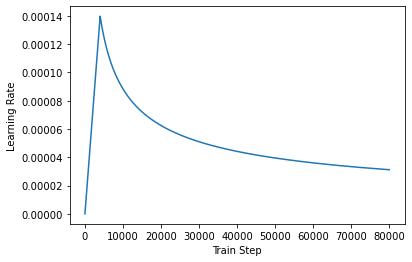

In [5]:
Scheduler = CustomSchedule(128, 4000)

plt.plot(Scheduler(tf.range(80000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


In [4]:
14*1562

21868

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

# lr = 1e-4
lr = CustomSchedule(128, 4000)
loss_classif     =  loss_cross # find the right loss for multi-class classification
optimizer        = Adam(lr, 1e-8) # find the right optimizer
metrics_classif  =  [acc]

model.compile(
            loss = loss_classif,
            optimizer=optimizer,
            metrics=metrics_classif)

In [ ]:
train_gen = DataGenerator(batch_size=64, max_len = max_len, folder = 'user_batch_saint_100', strategy = 'end', mask_rate = 0.15, seq_mask_rate = 1, bidirectionnal = False)
# test_gen = DataGenerator(batch_size=512, max_len = max_len, folder = 'user_batch_saint_test', strategy = 'end', mask_rate = 0.15, seq_mask_rate = 1, bidirectionnal = False)
# x_test, y_test = test_gen[0]
# x_train, y_train = train_gen[0]

In [ ]:
# save((x_test, y_test), 'comparable_test_set')

In [ ]:
(x_test, y_test) = load('comparable_test_set')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, verbose=1, 
                                                mode='auto', restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, 
                                                     mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


# history = CustomCallback(validation = (x_test,  y_test), dico_params = dico_params)#, from_path = './history_sb++/history_epoch_44')

# callbacks = [history]
callbacks = [AUCCallback(validation=(x_test, y_test), logs = {})]#, early, reduce]

batch_size = 64
n_epochs = 500
steps_per_epoch = 500

model.fit(train_gen, epochs=n_epochs,
                    steps_per_epoch = steps_per_epoch, 
                    validation_data=(x_test,  y_test), 
                    max_queue_size=20,
#                     workers=6,
                    callbacks = callbacks,
                    verbose = 1
                   )


In [ ]:
# model.save_weights('./weights_saint/saintgpt_8l_36_question_6.76_correct_70.75_auc_75.72.h5')

In [ ]:
test_gen = DataGenerator(batch_size=1500, max_len = max_len, folder = 'user_batch_saint_test', strategy = 'end', mask_rate = 0.15, seq_mask_rate = 1, bidirectionnal = False)
x_val, y_val = test_gen[0]

In [ ]:
pred = model.predict(x_val, verbose = 1)

In [ ]:
dir(model)

In [ ]:
y_val.shape

In [ ]:
# model.save_weights('./weights_saint/regression_gpt_0.782.h5')

In [ ]:
pred = pred[:,:,0]
true = y_val[:,:,0]

In [ ]:
m = 0
M = 128

y_pred = pred[:,m:M]
y_true = true[:,m:M]

y_pred = y_pred.reshape(y_true.shape[0] * y_true.shape[1])
y_true = y_true.reshape(y_true.shape[0] * y_true.shape[1])

y_pred = y_pred[y_true != 20]/10
y_true = y_true[y_true != 20]/10 

In [ ]:
y_true

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, (y_pred >= 0.5)*1)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_pred)

## Testing embedding with gbdt

In [ ]:
test_gen = DataGenerator(batch_size=1500, max_len = max_len, folder = 'user_batch_saint_test', strategy = 'end', mask_rate = 0.15, seq_mask_rate = 1, bidirectionnal = False)
x_val, y_val = test_gen[0]

# test_gen = DataGenerator(batch_size=64, max_len = max_len, folder = 'user_batch_saint_100', strategy = 'end', mask_rate = 0.15, seq_mask_rate = 1, bidirectionnal = False)
# x_val1, y_val1 = test_gen[0]

In [ ]:
model.summary()

In [ ]:
inp = model.inputs
out = model.get_layer('dense_56').output
model1 = Model(inp, out)

In [ ]:
x_val1, y_val2 = test_gen[0]
y_val2 = y_val2[:,:,0]/10
emb2 = model1.predict(x_val1)

In [ ]:
x_val1[-1].shape

In [ ]:
emb2.shape

In [ ]:
np.concatenate([emb2, x_val1[-1]], axis = -1).shape

In [ ]:
test_gen = DataGenerator(batch_size=64, max_len = max_len, folder = 'user_batch_saint_100', strategy = 'end', mask_rate = 0.15, seq_mask_rate = 1, bidirectionnal = False)
emb1 = None
y_val1 = None
for i in tqdm(range(100)):
    x_val1, y_val2 = test_gen[0]
    y_val2 = y_val2[:,:,0]/10
    emb2 = model1.predict(x_val1)
    emb2 = np.concatenate([emb2, x_val1[-1]], axis = -1)
    if emb1 is not None:
        emb1 = np.concatenate([emb1, emb2])
        y_val1 = np.concatenate([y_val1, y_val2])
    else:
        emb1 = deepcopy(emb2)
        y_val1 = deepcopy(y_val2)
        

In [ ]:
emb = model1.predict(x_val, verbose = 1)
emb = np.concatenate([emb, x_val[-1]], axis = -1)
# emb1 = model1.predict(x_val1, verbose = 1)

In [ ]:
emb1.shape

In [ ]:
y_val = y_val[:,:,0]/10

In [ ]:
Xt =  []
yt = []

for i, elt in enumerate(tqdm(x_val[0])):
    for j, ids in enumerate(elt):
        if ids != 1:
            if y_val[i,j] < 2:
                Xt.append(emb[i,j,:])
                yt.append(y_val[i, j])
                        
Xt = np.array(Xt)
yt = np.array(yt)

Xv = []
yv = []

for i, elt in enumerate(tqdm(emb1)):
    for j, ids in enumerate(elt):
        if y_val1[i,j] < 2:
                Xv.append(emb1[i,j,:])
                yv.append(y_val1[i, j])

Xv = np.array(Xv)
yv = np.array(yv)

In [ ]:
# ids_to_keep = np.random.choice(list(range(len(Xv))), size = 200000)
# Xv = Xv[ids_to_keep]
# yv = yv[ids_to_keep]

In [ ]:
np.unique(yt)

In [ ]:
Xv.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xv, yv, test_size=0.2, random_state=42)

In [ ]:
import umap

reducer = umap.UMAP(metric='cosine',
     n_components=32, n_neighbors=15, 
     verbose=True)

reducer.fit(X_train[:30000], y_train[:30000])

In [ ]:
from sklearn.decomposition import PCA
reducer = PCA(n_components=32)
reducer.fit(X_train[:30000])

In [ ]:
X_train1 = reducer.transform(X_train)
X_test1 = reducer.transform(X_test)
Xt1 = reducer.transform(Xt)

In [ ]:
save(reducer, 'umap_reducer')

In [ ]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(max_depth = -1, n_estimators = 500, n_jobs = 12, silent = False, early_stopping_rounds = 15)
clf.fit(X_train1, y_train, eval_set =(Xt1, yt), eval_metric = 'auc')

In [ ]:
pred = clf.predict(Xt1)

In [ ]:
accuracy_score(yt, pred)

In [ ]:
pred = clf.predict_proba(Xt1)[:,1]

In [ ]:
roc_auc_score(yt, pred)

In [ ]:
pred

In [ ]:
save(clf, 'lightgbm')

## Prediction

In [ ]:
class FakeDataGenerator:
    
    def __init__(self):
        '''
        self.data will be a dictionnary to iterate over the stored data
        self.all_rows will be the rows of the train set that are used by the generato
        self.data_index will be all the data available in the dataset        
        '''
        self.data = None
        self.all_rows = None
        self.data_index = None
        return None
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        sub = sample[['row_id', 'group_num']].copy()
        sub['answered_correctly'] = np.zeros(sub.shape[0])+0.5
        return (sample, sub)
    
    
    def load(self, save_name):
        self.data,self.all_rows = load(save_name)
        self.data_index = np.array(list(self.data.keys()))
    
    def build_from_train(self, train, n_users, beginner_rate = 0.3, save_name = 'fake_train_generator'):
        """
        train will be the training set you loaded
        n_users is a number of user from whom you will sample the data
        beginner_rate is the rate of these users who will begin their journey during test
        save_name : the name under which the item will be saved
        """
        
        ## Sampling a restricted list of users
        user_list = train['user_id'].unique()
        test_user_list = np.random.choice(user_list, size = n_users)
        train.index = train['user_id']
        test_data_non_filter = train.loc[test_user_list]
        test_data_non_filter.index = list(range(test_data_non_filter.shape[0]))
        
        ## building a dictionnary with all the rows and container id from a user
        dico_user = {}
        def agg(x):
            return [elt for elt in x]
        
        print("Generating user dictionnary")
        for user, frame in tqdm(test_data_non_filter.groupby('user_id'), total =test_data_non_filter['user_id'].nunique()):
            if frame.shape[0] > 0:
                dico_user[user] = {}

                dico_user[user]['min_indice'] = frame['task_container_id'].min()
                dico_user[user]['max_indice'] = frame['task_container_id'].max()

                r = random.uniform(0,1)
                if r < beginner_rate:
                    dico_user[user]['current_indice'] = dico_user[user]['min_indice']
                else:
                    dico_user[user]['current_indice'] = random.randint(dico_user[user]['min_indice'],dico_user[user]['max_indice']-2)

                row_ids = frame[['task_container_id','row_id']].groupby('task_container_id').agg(agg)
                row_ids = row_ids.to_dict()['row_id']
                dico_user[user]['row_ids'] = row_ids

        work_dico = deepcopy(dico_user)
        
        ## Choosing batch_data to generate
        work_dico = deepcopy(dico_user)
        batches = {}

        all_rows = []
        batch_number = 0
        
        print('Creating batches')
        while len(work_dico)> 1:

            size = random.randint(20,500)
            size = min(size, len(work_dico))


            batch = []

            users = np.random.choice(np.array(list(work_dico.keys())),replace = False,  size = size)

            for u in users:
                try:
                    batch.extend(work_dico[u]['row_ids'][work_dico[u]['current_indice']])
                    all_rows.extend(work_dico[u]['row_ids'][work_dico[u]['current_indice']])
                    work_dico[u]['current_indice'] += 1
                    if work_dico[u]['current_indice'] == work_dico[u]['max_indice']:
                        work_dico.pop(u)
                except:
                    work_dico.pop(u)

            batches[batch_number] = batch
            batch_number += 1
        
        ## building data

        data = {}
        
        print("Building dataset")
        test_data_non_filter.index = test_data_non_filter['row_id']
        for i in tqdm(batches):
            current_data = test_data_non_filter.loc[np.array(batches[i])]
            current_data['group_num'] = i

            current_data['prior_group_answers_correct'] = [np.nan for elt in range(current_data.shape[0])]
            current_data['prior_group_responses'] = [np.nan for elt in range(current_data.shape[0])]

            if i != 0:
                current_data['prior_group_answers_correct'].iloc[0] = saved_correct_answer
                current_data['prior_group_responses'].iloc[0] = saved_answer

            saved_answer = str(list(current_data[current_data['content_type_id'] == 0]['user_answer'].values))
            saved_correct_answer = str(list(current_data[current_data['content_type_id'] == 0]['answered_correctly'].values))
            current_data = current_data.drop(columns = ['user_answer', 'answered_correctly'])

            data[i] = current_data

        save((data,np.array(all_rows)) , save_name)
        
        self.data = data
        self.all_rows = np.array(all_rows)
        self.data_index = np.array(list(data.keys()))
        print('finished')

In [ ]:
env = FakeDataGenerator()
# env.build_from_train(train, 15000, beginner_rate = 0.3, save_name = 'fake_train_generator')
env.load('fake_train_generator')

In [ ]:
sample, sub = env[1]

In [ ]:
# train = load('train_train')

In [ ]:
train.index = train['user_id']

In [ ]:
def create():
    return {
                'exercise_id' : np.array([]),
                'container_id' : np.array([]),
                'timestamp' : np.array([]),
                'correctness' : np.array([]),
                'answer' : np.array([]), 
                'elapsed_time' : np.array([]),
                'prior_question_had_explanation' : np.array([]),
                'lag_time' : np.array([]),
                'first_line' : True
            }

def update_data(data, data_sav, sub_sav):
    prior_correct = data['prior_group_answers_correct'].iloc[0]
    prior_answer = data['prior_group_responses'].iloc[0]

    prior_correct = np.array(prior_correct.replace('[', '').replace(']', '').split(', ')).astype(int)
    prior_answer = np.array(prior_answer.replace('[', '').replace(']', '').split(', ')).astype(int)

    corr = np.zeros(data_sav.shape[0]) - 1 
    ans = np.zeros(data_sav.shape[0]) - 1

    boole = data_sav['content_type_id'].values == 0

    corr[boole] = prior_correct
    ans[boole] = prior_answer

    data_sav['answered_correctly'] = corr
    data_sav['user_answer'] = ans
    sub_sav['answered_correctly_truth'] = corr
    
    sub_sav = sub_sav[boole]
    
    return data_sav, sub_sav

def update_dico_user(dico_user, data_sav):
    data_sav = data_sav.sort_values(by = ['timestamp'])
    for i, line in data_sav.iterrows():
        user = line['user_id']
        exid = line['content_id']
        tid = line['content_type_id']
        exid = 'q_'+str(exid) if tid == 0 else 'l_' + str(exid)

        dico_user[user]['exercise_id'] = np.concatenate([dico_user[user]['exercise_id'], [exid]])
        dico_user[user]['container_id'] = np.concatenate([dico_user[user]['container_id'], [line['task_container_id']]])
        dico_user[user]['timestamp'] = np.concatenate([dico_user[user]['timestamp'], [line['timestamp']/1000]])
        dico_user[user]['correctness'] = np.concatenate([dico_user[user]['correctness'], [line['answered_correctly']]])
        dico_user[user]['answer'] = np.concatenate([dico_user[user]['answer'], [line['user_answer']]])

        ## two other depend on if this is the first line
        if dico_user[user]['first_line']:
            dico_user[user]['first_line'] = False
            dico_user[user]['lag_time'] = np.concatenate([dico_user[user]['lag_time'], [0]])

        else:
            el = line['prior_question_elapsed_time']
            if str(el) == 'nan':
                el = 0
            dico_user[user]['elapsed_time'] = np.concatenate([dico_user[user]['elapsed_time'], [el]])

            pr = line['prior_question_had_explanation']
            if str(pr) == 'nan':
                pr = 0
            pr = pr*1
            dico_user[user]['prior_question_had_explanation'] = np.concatenate([dico_user[user]['prior_question_had_explanation'], [pr]])

            lag = dico_user[user]['timestamp'][-1] - dico_user[user]['timestamp'][-2] + el
            if lag < 0:
                lag = 0
            dico_user[user]['lag_time'] = np.concatenate([dico_user[user]['lag_time'], [lag]])
    return dico_user


dico_question = load('dico_questions_mean')
dico_utags, dico_gtags, dico_parts = load('dico_tags')
timestamp_enc, elapsed_enc,lag_time_enc, qmean_enc = load('discrete_encoders')
tokenizer = load('tokenizer')

def map_part( ids):
    def replace_dico_part(x):
        try:
            return dico_parts[x]
        except:
            return 0
    return np.array(list(map(replace_dico_part,ids)))

def map_utags( ids):
    def replace_dico_utags(x):
        try:
            if str(dico_utags[x]) != 'nan':
                return str(self.dico_utags[x])
            else:
                return 0
        except:
            return 0
    return np.array(list(map(replace_dico_utags,ids)))

def map_gtags( ids):
    def replace_dico_gtags(x):
        try:
            if str(dico_gtags[x]) != 'nan':
                return str(dico_gtags[x])
            else:
                return 0
        except:
            return 0
    return np.array(list(map(replace_dico_gtags,ids)))

def map_mean(ids):
    def replace_dico_question(x):
        try:
            return dico_question[x]
        except:
            return 0.5
    return np.array(list(map(replace_dico_question,ids)))

def remove_na(x):
    x = np.array(list(x))
    x[np.isnan(x)] = 0
    return x

def build_sequence(user_history, new_inputs, max_len = 128):
    ## new input : (exercise_id, timestamp, elapsed)
    
    dico_sequence = deepcopy(user_history)        
    dico_sequence['elapsed_time'] = remove_na(dico_sequence['elapsed_time'])
    dico_sequence['lag_time'] = remove_na(dico_sequence['lag_time'])
    dico_sequence['prior_question_had_explanation'] = remove_na(dico_sequence['prior_question_had_explanation'])

    dico_sequence['elapsed_time'] = np.concatenate([dico_sequence['elapsed_time'], [0]])
    dico_sequence['prior_question_had_explanation'] = np.concatenate([dico_sequence['prior_question_had_explanation'], [0]])


    ## Cut sequence
    for elt in dico_sequence:
        if elt != 'first_line':
            dico_sequence[elt] = dico_sequence[elt][-(max_len-1):]
        
    ## Adding new elements
    dico_sequence['exercise_id'] = np.concatenate([dico_sequence['exercise_id'], [new_inputs[0]]])
    dico_sequence['timestamp'] = np.concatenate([dico_sequence['timestamp'], [new_inputs[1]]])
    try:
        lag = dico_sequence['timestamp'][-1] - dico_sequence['timestamp'][-2] + new_inputs[2]
    except:
        lag = 0
    if lag < 0:
        lag = 0
    dico_sequence['lag_time'] = np.concatenate([dico_sequence['lag_time'], [lag]])
    query_id = len(dico_sequence['exercise_id']) - 1
    
    ## Pad sequence
    pad_tokens = ['[PAD]', 0, 0, -1, -1, 0, 0, 0, '[PAD]', -1, -1]
    for j, elt in enumerate(dico_sequence):
        if elt != 'first_line':
            size = len(dico_sequence[elt])
            if size <= max_len:
                adding = max_len - size
                tok = pad_tokens[j]
                if type(tok) == str:
                    add = np.array([tok for elt in range(adding)])
                else:
                    add = np.zeros(adding) + tok
                dico_sequence[elt] = np.concatenate([dico_sequence[elt], add], axis = 0)
#                 print(dico_sequence[elt].shape)
    lags =  lag_time_enc.transform(dico_sequence['lag_time'])
    lags[lags<0] = 0
    
    input_vals = [
        dico_sequence['exercise_id'],
        map_part(dico_sequence['exercise_id']),
        map_utags(dico_sequence['exercise_id']),
        map_gtags(dico_sequence['exercise_id']),
        timestamp_enc.transform(dico_sequence['timestamp']),
        qmean_enc.transform(map_mean(dico_sequence['exercise_id'])),

        np.concatenate([[0], dico_sequence['correctness'] + 1])[:-1],
        np.concatenate([[0], dico_sequence['answer'] + 1])[:-1],
        np.concatenate([[0], elapsed_enc.transform(dico_sequence['elapsed_time'])])[:-1],
        lags,
        np.concatenate([[0], dico_sequence['prior_question_had_explanation']])[:-1],
    ]
    return input_vals, query_id

def initiate_dico(batch_size, max_len = 128):
    list_encoder = ['exercise', 'part', 'utag', 'gtag', 'timestamp', 'question_mean']
    list_decoder = ['correct', 'answer', 'elapsed_time', 'lag_time', 'was_explained']
    list_output = ['exercise', 'answer', 'correct']

    dico_input = {}
    for elt in list_encoder + list_decoder:
        if elt == 'exercise':
            dico_input[elt] = np.zeros((batch_size, max_len)).astype(str)
        else:
            dico_input[elt] = np.zeros((batch_size, max_len)).astype('int32')
    return dico_input

def update_dico(dico_input, input_vals, i):
    list_encoder = ['exercise', 'part', 'utag', 'gtag', 'timestamp', 'question_mean']
    list_decoder = ['correct', 'answer', 'elapsed_time', 'lag_time', 'was_explained']
    list_output = ['exercise', 'answer', 'correct']

    for j, elt in enumerate(list_encoder + list_decoder):
        dico_input[elt][i] = input_vals[j]
    return dico_input

In [ ]:
sample.head()

In [ ]:
dico_user = {}
data_sav = None
count = 0

all_sub = None

for i in tqdm(env.data_index):
    data, sub = env[i]
    
    for elt in data['user_id'].unique():
        # Loading every piece of information available from past
        if not(elt in dico_user):
            try:
#                 print(elt)
                dico_user[elt] = load(str(elt), 'ind_user')
                dico_user[elt]['first_line'] = False
            except:
                dico_user[elt] = create()
        
    ## Updating data_sav with the new informations
    if count != 0:
        ## Include values in the mix
        data_sav, sub_sav = update_data(data, data_sav, sub_sav)
        
        if all_sub is not None:
            all_sub = pd.concat([all_sub, sub_sav])
        else:
            all_sub = sub_sav.copy()
        print(roc_auc_score(all_sub['answered_correctly_truth'], all_sub['answered_correctly']))
        
        ## Update dictionnary with data of previous batch
        dico_user = update_dico_user(dico_user, data_sav)
    
    ## Build input for the deep learning model
    dico_input = initiate_dico(data.shape[0])
    
    data.reset_index(drop = True, inplace = True)
    
    query_ids = []
    for i, line in data.iterrows():
        user = line['user_id']
        exid = line['content_id']
        tid = line['content_type_id']
        exid = 'q_'+str(exid) if tid == 0 else 'l_' + str(exid)
        
        t = line['timestamp'] / 1000
        el = line['prior_question_elapsed_time'] / 1000
        
        input_vals, query_id = build_sequence(dico_user[user], (exid, t, el))
        query_ids.append(query_id)
        dico_input = update_dico(dico_input, input_vals, i)
    
    x = deepcopy(dico_input['exercise'])
    dico_input['exercise'] = np.array(tokenizer.texts_to_sequences([" ".join(list(x)[elt]) for elt in range(len(x))]))
    
    X = list(np.array(list(dico_input.values())).astype('int32'))
    
    ## Lgbm variant
    predicted = model1.predict(X)
    X1 = []
    
    print(query_ids)
    
    for i, j in enumerate(query_ids):
        X1.append(predicted[i,j,:])
    X1 = np.array(X1)
    p = clf.predict_proba(X1)[:,1]
    
    ## Deep Variant
#     p1 = model.predict(X)[2][:,:,2]
    
#     p = []
#     for i, j in enumerate(query_ids):
#         p.append(p1[i,j])
    
    sub['answered_correctly'] = p
                
    data_sav = data.copy()
    sub_sav = sub.copy()
    count += 1
    

In [ ]:
sub

In [ ]:
X1

In [ ]:
import tensorflow as tf
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,batch_size=32, max_len = 128, folder = 'user_batch_saint_100', strategy = 'begin', mask_rate = 0.15, seq_mask_rate = 0.5, bidirectionnal = True):
        self.batch_size = batch_size
        self.tokenizer = load('tokenizer')
        self.max_len = max_len
        self.folder = folder
        self.dico_question = load('dico_questions_mean')
        self.dico_utags, self.dico_gtags, self.dico_parts = load('dico_tags')
        self.timestamp_enc, self.elapsed_enc,self.lag_time_enc, self.qmean_enc = load('discrete_encoders')
        self.strategy = strategy
        self.mask_rate = mask_rate
        self.seq_mask_rate = seq_mask_rate
        self.bidirectionnal = bidirectionnal
        
    def __len__(self):
        return 1000000
    
    def initiate_dico(self):
        list_encoder = ['exercise', 'part', 'utag', 'gtag', 'timestamp', 'question_mean']
        list_decoder = ['correct', 'answer', 'elapsed_time', 'lag_time', 'was_explained']
        list_output = ['exercise', 'answer', 'correct']
        
        dico_input = {}
        for elt in list_encoder + list_decoder:
            if elt == 'exercise':
                dico_input[elt] = np.zeros((self.batch_size, self.max_len)).astype(str)
            else:
                dico_input[elt] = np.zeros((self.batch_size, self.max_len)).astype('int32')
        
        dico_output = {}
        for elt in list_output:
            if elt == 'exercise':
                dico_output[elt] = np.zeros((self.batch_size, self.max_len)).astype(str)
            else:
                dico_output[elt] = np.zeros((self.batch_size, self.max_len)).astype('int32')
        return dico_input, dico_output

    def map_part(self, ids):
        def replace_dico_part(x):
            try:
                return self.dico_parts[x]
            except:
                return 0
        return np.array(list(map(replace_dico_part,ids)))
    
    def map_utags(self, ids):
        def replace_dico_utags(x):
            try:
                if str(self.dico_utags[x]) != 'nan':
                    return str(self.dico_utags[x])
                else:
                    return 0
            except:
                return 0
        return np.array(list(map(replace_dico_utags,ids)))
    
    def map_gtags(self, ids):
        def replace_dico_gtags(x):
            try:
                if str(self.dico_gtags[x]) != 'nan':
                    return str(self.dico_gtags[x])
                else:
                    return 0
            except:
                return 0
        return np.array(list(map(replace_dico_gtags,ids)))
    
    def map_mean(self, ids):
        def replace_dico_question(x):
            try:
                return self.dico_question[x]
            except:
                return 0.5
        return np.array(list(map(replace_dico_question,ids)))


    
    def update_dico(self, dico_input, dico_output, input_vals, output_vals, i):
        list_encoder = ['exercise', 'part', 'utag', 'gtag', 'timestamp', 'question_mean']
        list_decoder = ['correct', 'answer', 'elapsed_time', 'lag_time', 'was_explained']
        list_output = ['exercise', 'answer', 'correct']
        
        for j, elt in enumerate(list_encoder + list_decoder):
            dico_input[elt][i] = input_vals[j]
        
        for j, elt in enumerate(list_output):
            dico_output[elt][i] = output_vals[j]
        return dico_input, dico_output

    def remove_na(self, x):
        x = np.array(list(x))
        x[np.isnan(x)] = 0
        return x
    
    def apply_mask(self, x, mask, pad_token, mask_token):
        x_out = []
        x_in = []
        for i, elt in enumerate(mask):
            if mask[i] == 1:
                x_out.append(x[i])
                x_in.append(mask_token)
            else:
                x_out.append(pad_token)
                x_in.append(x[i])
        return np.array(x_in), np.array(x_out)

    def build_sequence(self, user_history):
        dico_sequence = deepcopy(user_history)        
        dico_sequence['elapsed_time'] = self.remove_na(dico_sequence['elapsed_time'])
        dico_sequence['lag_time'] = self.remove_na(dico_sequence['lag_time'])
        dico_sequence['prior_question_had_explanation'] = self.remove_na(dico_sequence['prior_question_had_explanation'])
        
        dico_sequence['elapsed_time'] = np.concatenate([dico_sequence['elapsed_time'], [0]])
        dico_sequence['prior_question_had_explanation'] = np.concatenate([dico_sequence['prior_question_had_explanation'], [0]])
        
        
        ## Cut sequence
        if self.strategy == 'begin':
            for elt in dico_sequence:
                dico_sequence[elt] = dico_sequence[elt][:self.max_len]
        else:
            for elt in dico_sequence:
                dico_sequence[elt] = dico_sequence[elt][-self.max_len:]
        
        
        
         ## Masking
        # Either mask question => mask parts, qmean, answer, correctness 0.5%
        # Or mask correctness => mask answer, elapsed_time, lag_time, explanation 0.5%
        # In all case, mask the last question answer, but we keep its signification
        
        if self.bidirectionnal == True:
            r = random.uniform(0,1)
            if r < self.seq_mask_rate:
                # masking on the question_id
                masks = np.random.choice([0,1],replace = True, size = len(dico_sequence['exercise_id'])-1, p = [1-self.mask_rate,self.mask_rate])

    #             print(masks.shape)
    #             print(dico_sequence['elapsed_time'].shape)
    #             print('\n')

                dico_sequence['elapsed_time'], _ = self.apply_mask(dico_sequence['elapsed_time'], masks, 0, 0)     
                dico_sequence['prior_question_had_explanation'], _ = self.apply_mask(dico_sequence['prior_question_had_explanation'], masks, 0, 0) 

                masks = np.concatenate([masks, [0]])
                dico_sequence['exercise_id'], dico_sequence['exercise_id_out'] = self.apply_mask(dico_sequence['exercise_id'], masks, '[PAD]', '[MASK]')            
                masks[-1] = 1
                dico_sequence['answer'], dico_sequence['answer_out'] = self.apply_mask(dico_sequence['answer'], masks, -1, -1)
                dico_sequence['correctness'], dico_sequence['correctness_out'] = self.apply_mask(dico_sequence['correctness'], masks, -1, -1)

            else:
                # Masking only a part of the answers
                dico_sequence['exercise_id_out'] = deepcopy(np.array(['[PAD]' for elt in dico_sequence['exercise_id']]))
                masks = np.random.choice([0,1],replace = True, size = len(dico_sequence['correctness'])-1, p = [1-self.mask_rate,self.mask_rate])

    #             print(masks.shape)
    #             print(dico_sequence['elapsed_time'].shape)
    #             print('\n')

                dico_sequence['elapsed_time'], _ = self.apply_mask(dico_sequence['elapsed_time'], masks, 0, 0)    
                dico_sequence['prior_question_had_explanation'], _ = self.apply_mask(dico_sequence['prior_question_had_explanation'], masks, 0, 0)

                masks = np.concatenate([masks, [1]])
                dico_sequence['correctness'], dico_sequence['correctness_out'] = self.apply_mask(dico_sequence['correctness'], masks, -1, -1)
                dico_sequence['answer'], dico_sequence['answer_out'] = self.apply_mask(dico_sequence['answer'], masks, -1, -1)
        
        else:
            dico_sequence['exercise_id_out'] = dico_sequence['exercise_id']
            dico_sequence['correctness_out'] = dico_sequence['correctness']
            dico_sequence['answer_out'] = dico_sequence['answer']
        
        ## Pad sequence
        pad_tokens = ['[PAD]', 0, 0, -1, -1, 0, 0, 0, '[PAD]', -1, -1]
        for j, elt in enumerate(dico_sequence):
            size = len(dico_sequence[elt])
            if size <= self.max_len:
                adding = self.max_len - size
                tok = pad_tokens[j]
                if type(tok) == str:
                    add = np.array([tok for elt in range(adding)])
                else:
                    add = np.zeros(adding) + tok
                dico_sequence[elt] = np.concatenate([dico_sequence[elt], add], axis = 0)
#                 print(dico_sequence[elt].shape)

        if self.bidirectionnal == False:
            input_vals = [
                dico_sequence['exercise_id'],
                self.map_part(dico_sequence['exercise_id']),
                self.map_utags(dico_sequence['exercise_id']),
                self.map_gtags(dico_sequence['exercise_id']),
                self.timestamp_enc.transform(dico_sequence['timestamp']),
                self.qmean_enc.transform(self.map_mean(dico_sequence['exercise_id'])),

                np.concatenate([[0], dico_sequence['correctness'] + 1])[:-1],
                np.concatenate([[0], dico_sequence['answer'] + 1])[:-1],
                np.concatenate([[0], self.elapsed_enc.transform(dico_sequence['elapsed_time'])])[:-1],
                self.lag_time_enc.transform(dico_sequence['lag_time']),
                np.concatenate([[0], dico_sequence['prior_question_had_explanation']])[:-1],
            ]

            output_vals = [
                np.concatenate([dico_sequence['exercise_id_out'][1:], ['[PAD]']]),
                dico_sequence['answer_out'] + 1,
                dico_sequence['correctness_out'] + 1,
            ]
            
        else:
            input_vals = [
                dico_sequence['exercise_id'],
                self.map_part(dico_sequence['exercise_id']),
                self.map_utags(dico_sequence['exercise_id']),
                self.map_gtags(dico_sequence['exercise_id']),
                self.timestamp_enc.transform(dico_sequence['timestamp']),
                self.qmean_enc.transform(self.map_mean(dico_sequence['exercise_id'])),

                dico_sequence['correctness'] + 1,
                dico_sequence['answer'] + 1,
                self.elapsed_enc.transform(dico_sequence['elapsed_time']),
                self.lag_time_enc.transform(dico_sequence['lag_time']),
                dico_sequence['prior_question_had_explanation'],
            ]

            output_vals = [
                dico_sequence['exercise_id_out'],
                dico_sequence['answer_out'] + 1,
                dico_sequence['correctness_out'] + 1,
            ]
        
        
#         x = np.zeros((11,self.max_len))
#         y = np.zeros((3, self.max_len))
        return input_vals,output_vals
    

    def __getitem__(self, index):
        ## Load random batch
        file_name = random.choice(os.listdir('./'+self.folder))
        dico_user = load(file_name.split('.')[0], self.folder)
        
        list_user = np.random.choice(list(dico_user.keys()), size = self.batch_size)
        
        dico_input, dico_output = self.initiate_dico()
        
        
        for i, elt in enumerate(list_user):
            user_history = dico_user[elt]
            input_vals, output_vals = self.build_sequence(user_history)
            dico_input, dico_output = self.update_dico(dico_input, dico_output, input_vals, output_vals, i)
        
        x = deepcopy(dico_input['exercise'])
        dico_input['exercise'] = np.array(self.tokenizer.texts_to_sequences([" ".join(list(x)[elt]) for elt in range(len(x))]))
        
        x = deepcopy(dico_output['exercise'])
        dico_output['exercise'] = np.array(self.tokenizer.texts_to_sequences([" ".join(list(x)[elt]) for elt in range(len(x))]))
        
        X = list(np.array(list(dico_input.values())).astype('int32'))
        y = list(np.array(list(dico_output.values())).astype('int32')) 
        
        return X, y

    def on_epoch_end(self):
        pass

    def __get_data(self, batch):
        pass

In [ ]:
def build_user_sequence(df_user):
    import numpy as np
    df_user =  df_user.sort_values(by = 'timestamp')
    df_user.index = list(range(df_user.shape[0]))
    
    df_user['content_type'] =  df_user['content_type_id'].apply(lambda x : 'q' if x == 0 else 'l')
    df_user['content_seq'] = df_user['content_type'].astype(str) + '_' + df_user['content_id'].astype(str)
    
    ## Encoder
    exercise_id = df_user['content_seq'].values
    container_id = df_user['task_container_id'].values
    timestamp = df_user['timestamp'].values/1000  ## Conversion in s
    
    ## Decoder
    correctness = df_user['answered_correctly'].values
    answer = df_user['user_answer'].values
    
    elapsed_time = df_user['prior_question_elapsed_time'].fillna(0).values[1:]/1000 ## Already Padded ## Conversion in s
    prior_question_had_explanation = df_user['prior_question_had_explanation'].fillna(0).values[1:]*1 ## Already Padded
    
    lag_time = np.concatenate([[0],timestamp[1:] - timestamp[:-1] + elapsed_time])
    
    dico = {
        'exercise_id' : exercise_id,
        'container_id' : container_id,
        'timestamp' : timestamp,
        'correctness' : correctness,
        'answer' : answer, 
        'elapsed_time' : elapsed_time,
        'prior_question_had_explanation' : prior_question_had_explanation,
        'lag_time' : lag_time
    }
    return dico

In [ ]:
a = 0
b = 0
for elt in tqdm(dico_user.keys()):
    c = dico_user[elt]
    if len(c['exercise_id']) <= 1:
        a += 1
    else:
        b+=1

In [ ]:
a

In [ ]:
b

## Ameliorations

add context on lecture and tasks

cluster lecture and tasks

give average score of a given task

enhance test set with train set (optimization constraint)
